# Lib

In [44]:
%load_ext autoreload
%autoreload 2

import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import glob

if sys.platform=='win32':
    sys.path.insert(0,".\..\src")
        
elif sys.platform=='linux':
    sys.path.insert(0,"./../src")

from utils import utils_ml, parameters


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
if sys.platform=='win32':
    !dir .\
        
elif sys.platform=='linux':
    !ls ./

1.EA.ipynb  2.Feature_engineering.ipynb


# Reading

In [25]:
## para saber en que directório uno se encuentra
#
if sys.platform=='win32':
    !echo %cd%
        
elif sys.platform=='linux':
    !pwd

/home/caanpaip/Documents/GitHub/ML-anti-fraud/notebooks


In [30]:
if sys.platform=='win32':
    df = pd.read_csv('.\..\data\dados.csv', sep=',', decimal=".")
        
elif sys.platform=='linux':
    df = pd.read_csv('./../data/dados.csv', sep=',', decimal=".")


## dropping column "o" becaise it has 78% missing. and this is a boolean columns
# df.drop("o", axis=1, inplace=True)

In [31]:
df

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,4,0.8191,21393.63,7.0,0.000000,1.0,BR,4,Aparelho Lipocavitação Ultrassônico + Gel Cond...,cat_a5b2091,0.808366,2009.0,434.0,1,NaN,N,2020-04-11 19:31:07,47.15,95,0
149996,4,NaN,NaN,24.0,0.384615,11.0,UY,20,"Sellos De Goma Automaticos, Personalizados.",cat_e39ab7e,0.989981,499.0,135.0,1,NaN,Y,2020-03-11 20:21:35,9.69,0,0
149997,4,NaN,NaN,3.0,0.477778,1.0,BR,19,Hélice 3 Pás Alumínio Rabeta 6.5 Hp Pesca Barc...,cat_ee6ecc8,0.763939,127.0,127.0,1,NaN,Y,2020-03-11 19:36:07,5.97,15,0
149998,4,0.6067,152906.86,1.0,0.099175,133.0,BR,3,Tela Display Lcd Galaxy J7 Neo J701 Com Brilho...,cat_237e2d0,0.382728,4373.0,123.0,1,NaN,Y,2020-03-16 07:13:24,25.83,59,0


# EA

In [32]:
df.rename(columns={"a":"a_int",
                    "p":"p_boolean","n":'n_boolean',
                     "k":"k_float","e":"e_float","h":"h_float","l":"l_float","f":"f_float","m":"m_float","m":"m_float","b":"b_float","c":"c_float","d":"d_float","o":"o_obj",
                     'i': 'produto','j':'categoria_produto','g':'pais'}
       , inplace = True)

## Transform categorical features
df['n_boolean'] = df['n_boolean'].astype("category")
df['p_boolean'] = df['p_boolean'].astype("category")


## creating columns os date and hour
df['data'] = df['fecha'].apply(lambda x: x[:10])
df['hora'] = df['fecha'].apply(lambda x: x[10:])

# WoE transformation

In [33]:
cats_cols = utils_ml.list_subset_words( df.columns.tolist() , ["bool","cat",'obj','pais'])
numeric_cols = [x for x in df.columns.tolist() if df[x].dtype.name!="object" and df[x].dtype.name!="category" and x!="fraude" ]

features = cats_cols + numeric_cols
## Tirando o score
features = features[:-1]
features

['n_boolean',
 'p_boolean',
 'categoria_produto',
 'o_obj',
 'pais',
 'a_int',
 'b_float',
 'c_float',
 'd_float',
 'e_float',
 'f_float',
 'h_float',
 'k_float',
 'l_float',
 'm_float',
 'monto']

In [34]:
dff = df.copy()

for variable in features:

    label = "fraude"
    dtype_ = 'categorical' if df[variable].dtype=='O' or df[variable].dtype=='category' else 'numerical'
    monotonic = True
    save_path_pkl = '.\..\src\\features\\'


    df = utils_ml.encode_woe_var(df, variable, label, dtype_, monotonic = True, save_path_pkl = None )

In [35]:
features_bins_woe = utils_ml.list_subset_words( df.columns.tolist(), ["bin"])
features_bins_woe

['n_boolean_bins',
 'p_boolean_bins',
 'categoria_produto_bins',
 'o_obj_bins',
 'pais_bins',
 'a_int_bins',
 'b_float_bins',
 'c_float_bins',
 'd_float_bins',
 'e_float_bins',
 'f_float_bins',
 'h_float_bins',
 'k_float_bins',
 'l_float_bins',
 'm_float_bins',
 'monto_bins']

In [36]:
len(features_bins_woe)

16

# Model

In [37]:
df_2_model = df[features_bins_woe + ["fraude"]]

In [38]:
cat_vars = features_bins_woe
df_2_model_dum = df_2_model.copy()

for var in cat_vars:

    cat_list='var'+'_'+var
    cat_list = pd.get_dummies( df_2_model_dum[var] , prefix=var)
    data_dum = df_2_model_dum.join(cat_list)
    df_2_model_dum = data_dum


data_vars = df_2_model_dum.columns.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

df_2_model_dum = df_2_model_dum[to_keep]


In [39]:
from sklearn.model_selection import train_test_split

X = df_2_model_dum.drop(['fraude'], axis=1)
y = df_2_model_dum['fraude']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0, stratify=y )

## Logistic regression

In [67]:
y.value_counts(normalize=True)[0]/y.value_counts(normalize=True)[1]

18.999999999999996

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=0,solver='newton-cg', fit_intercept=True, penalty='l2' )

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='recall', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   4.6s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   5.2s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   5.4s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   5.5s
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   6.4s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   8.4s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   8.5s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   9.3s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   7.7s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   8.4s
[CV] END class_weight={0: 0.009949748743718593, 1: 0.9900502512562814}; tota

In [76]:
# LogisticRegression??

In [74]:
clf = LogisticRegression( random_state=0, solver='saga',l1_ratio = 0.1, fit_intercept=True, penalty='elasticnet', class_weight = "balanced" )

model = clf.fit(X_train, y_train )

/home/caanpaip/miniconda3/envs/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [77]:
df_2_model['probabilty'] = model.predict_proba(X)[:,1]

/tmp/ipykernel_9512/2283094811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_model['probabilty'] = model.predict_proba(X)[:,1]


<AxesSubplot: xlabel='weight', ylabel='score'>

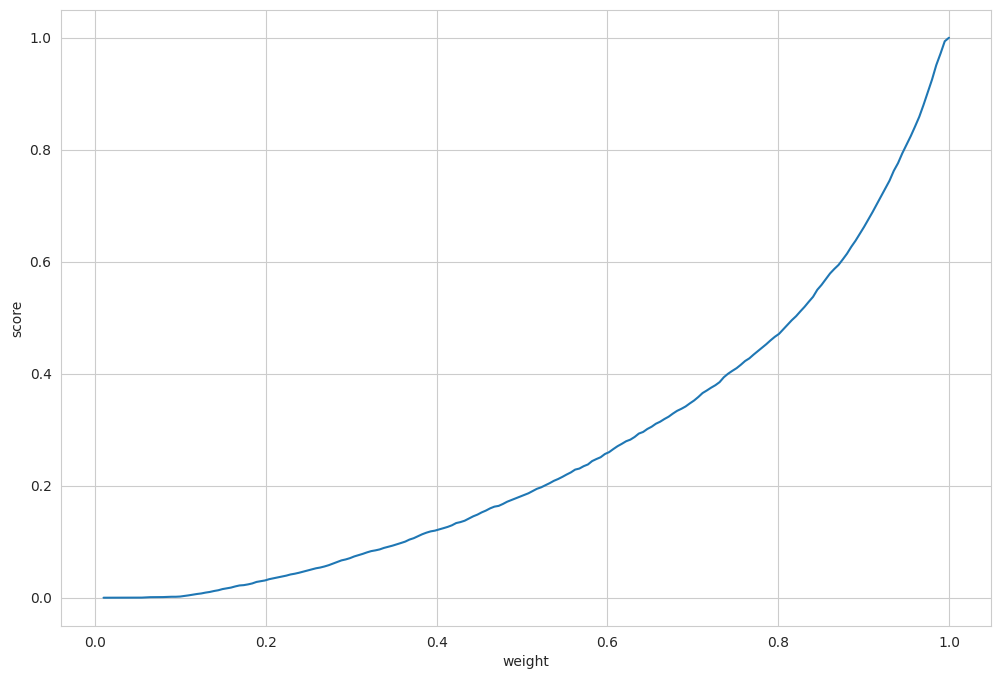

In [61]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data,  x='weight', y='score')
# plt.xlabel('Weight for class 1')
# plt.ylabel('F1 score')
# plt.xticks([round(i/10,1) for i in range(0,11,1)])
# plt.title('Scoring for different class weights', fontsize=24)

In [81]:
df_ivs_ls = []

for variable in dff.columns.tolist():

    label = "fraude"
    dtype_ = 'categorical' if dff[variable].dtype=='O' or dff[variable].dtype=='category' else 'numerical'

    df_iv = utils_ml.WOE_IV(df = dff , variable = variable, dtype_ = dtype_ , label = label, monotonic= True)[[ 'variable' , 'IV_var', 'KS']].drop_duplicates()

    df_ivs_ls.append(df_iv)

pd.concat(df_ivs_ls).sort_values("IV_var", ascending=False)

,variable,IV_var,KS
0,fecha,12.113640,99.544561
0,produto,6.369097,88.306667
0,hora,4.346361,84.314386
0,categoria_produto,1.641776,39.766316
0,o_obj,1.094238,44.994386
0,score,1.021894,43.152982
0,f_float,0.447805,27.785965
0,l_float,0.439939,25.305965
0,n_boolean,0.361450,22.844211
0,m_float,0.337380,22.929825


In [78]:
coef_df = pd.DataFrame( {"Cols": model.feature_names_in_,  "coef": model.coef_[0] })
coef_df.sort_values("coef", ascending=False)

,Cols,coef
14,categoria_produto_bins_10,3.772181
82,m_float_bins_1,2.835021
15,categoria_produto_bins_11,2.560564
18,o_obj_bins_1,1.784606
9,categoria_produto_bins_5,1.609129
69,l_float_bins_1,1.338140
81,m_float_bins_0,1.281945
39,d_float_bins_3,1.252341
75,l_float_bins_7,1.166217
47,f_float_bins_1,1.163016


In [ ]:
probability = "score"
label="fraude"
quantil=10

utils_ml.metric_evaluation(df, probability, label, quantil)

,total,faixa_prob,total_um,total_zero,TP,FP,TN,FN,perc_um,perc_zero,csum_um,csum_zero,ks,recall,precision,specificity,F1,F2
quantil,,,,,,,,,,,,,,,,,,
0,15000,"[0, 8]",417,14583,7500,142500,0,0,5.560000,10.233684,5.560000,10.233684,42.42807,1.000000,0.050000,0.000000,0.095238,0.208333
1,15000,"[8, 18]",694,14306,7083,127917,14583,417,9.253333,10.039298,14.813333,20.272982,42.42807,0.944400,0.052467,0.102337,0.099411,0.214636
2,15000,"[18, 28]",492,14508,6389,113611,28889,1111,6.560000,10.181053,21.373333,30.454035,42.42807,0.851867,0.053242,0.202730,0.100220,0.212967
3,15000,"[28, 38]",45,14955,5897,99103,43397,1603,0.600000,10.494737,21.973333,40.948772,42.42807,0.786267,0.056162,0.304540,0.104836,0.218407
4,15000,"[38, 48]",91,14909,5852,84148,58352,1648,1.213333,10.462456,23.186667,51.411228,42.42807,0.780267,0.065022,0.409488,0.120041,0.243833
5,15000,"[48, 58]",195,14805,5761,69239,73261,1739,2.600000,10.389474,25.786667,61.800702,42.42807,0.768133,0.076813,0.514112,0.139661,0.274333
6,15000,"[58, 68]",293,14707,5566,54434,88066,1934,3.906667,10.320702,29.693333,72.121404,42.42807,0.742133,0.092767,0.618007,0.164919,0.309222
7,15000,"[68, 78]",783,14217,5273,39727,102773,2227,10.440000,9.976842,40.133333,82.098246,42.42807,0.703067,0.117178,0.721214,0.200876,0.351533
8,15000,"[78, 88]",1295,13705,4490,25510,116990,3010,17.266667,9.617544,57.400000,91.715789,42.42807,0.598667,0.149667,0.820982,0.239467,0.374167


In [79]:
probability = "probabilty"
label="fraude"
quantil=10

utils_ml.metric_evaluation(df_2_model, probability, label, quantil)

,total,faixa_prob,total_um,total_zero,TP,FP,TN,FN,perc_um,perc_zero,csum_um,csum_zero,ks,recall,precision,specificity,F1,F2
quantil,,,,,,,,,,,,,,,,,,
0,15000,"[6.252292182237895e-11, 1.5407916538275171e-06]",2,14998,7500,142500,0,0,0.026667,10.524912,0.026667,10.524912,52.392982,1.000000,0.050000,0.000000,0.095238,0.208333
1,15000,"[1.5411497531130377e-06, 2.8416336743983467e-05]",12,14988,7498,127502,14998,2,0.160000,10.517895,0.186667,21.042807,52.392982,0.999733,0.055541,0.105249,0.105235,0.227212
2,15000,"[2.8419583485992328e-05, 0.0003183443394388212]",96,14904,7486,112514,29986,14,1.280000,10.458947,1.466667,31.501754,52.392982,0.998133,0.062383,0.210428,0.117427,0.249533
3,15000,"[0.0003183550525651636, 0.0016153505865386328]",173,14827,7390,97610,44890,110,2.306667,10.404912,3.773333,41.906667,52.392982,0.985333,0.070381,0.315018,0.131378,0.273704
4,15000,"[0.0016154123547990067, 0.00586593409276533]",287,14713,7217,82783,59717,283,3.826667,10.324912,7.600000,52.231579,52.392982,0.962267,0.080189,0.419067,0.148041,0.300708
5,15000,"[0.0058660170245860566, 0.018968580703150276]",392,14608,6930,68070,74430,570,5.226667,10.251228,12.826667,62.482807,52.392982,0.924000,0.092400,0.522316,0.168000,0.330000
6,15000,"[0.01897049757942422, 0.062050812155138114]",555,14445,6538,53462,89038,962,7.400000,10.136842,20.226667,72.619649,52.392982,0.871733,0.108967,0.624828,0.193719,0.363222
7,15000,"[0.06205176399872563, 0.21779708435772654]",874,14126,5983,39017,103483,1517,11.653333,9.912982,31.880000,82.532632,52.392982,0.797733,0.132956,0.726196,0.227924,0.398867
8,15000,"[0.2178099504418494, 0.6708569439895985]",1507,13493,5109,24891,117609,2391,20.093333,9.468772,51.973333,92.001404,52.392982,0.681200,0.170300,0.825326,0.272480,0.425750


In [80]:
df_test = pd.DataFrame()
df_test['fraude'] = y_test
df_test['probabilty'] = model.predict_proba(X_test)[:,1]

probability = "probabilty"
label="fraude"
quantil=10

utils_ml.metric_evaluation(df_test, probability, label, quantil)

,total,faixa_prob,total_um,total_zero,TP,FP,TN,FN,perc_um,perc_zero,csum_um,csum_zero,ks,recall,precision,specificity,F1,F2
quantil,,,,,,,,,,,,,,,,,,
0,4500,"[2.396255058732618e-10, 1.5855676654949483e-06]",0,4500,2250,42750,0,0,0.000000,10.526316,0.000000,10.526316,51.415205,1.000000,0.050000,0.000000,0.095238,0.208333
1,4500,"[1.5859808027354096e-06, 3.0610923718405375e-05]",3,4497,2250,38250,4500,0,0.133333,10.519298,0.133333,21.045614,51.415205,1.000000,0.055556,0.105263,0.105263,0.227273
2,4500,"[3.0634114193085304e-05, 0.0003322859025773517]",33,4467,2247,33753,8997,3,1.466667,10.449123,1.600000,31.494737,51.415205,0.998667,0.062417,0.210456,0.117490,0.249667
3,4500,"[0.00033239017507906204, 0.0016224921585736903]",59,4441,2214,29286,13464,36,2.622222,10.388304,4.222222,41.883041,51.415205,0.984000,0.070286,0.314947,0.131200,0.273333
4,4500,"[0.0016228355860153402, 0.00591126438191922]",87,4413,2155,24845,17905,95,3.866667,10.322807,8.088889,52.205848,51.415205,0.957778,0.079815,0.418830,0.147350,0.299306
5,4500,"[0.00591134488850258, 0.018824186141402095]",112,4388,2068,20432,22318,182,4.977778,10.264327,13.066667,62.470175,51.415205,0.919111,0.091911,0.522058,0.167111,0.328254
6,4500,"[0.01882651708393799, 0.062121204740591976]",182,4318,1956,16044,26706,294,8.088889,10.100585,21.155556,72.570760,51.415205,0.869333,0.108667,0.624702,0.193185,0.362222
7,4500,"[0.06212566005773768, 0.2154882743177884]",281,4219,1774,11726,31024,476,12.488889,9.869006,33.644444,82.439766,51.415205,0.788444,0.131407,0.725708,0.225270,0.394222
8,4500,"[0.2155338789449644, 0.6601349375063472]",418,4082,1493,7507,35243,757,18.577778,9.548538,52.222222,91.988304,51.415205,0.663556,0.165889,0.824398,0.265422,0.414722


# Catboost

In [85]:
import catboost as cb

In [102]:
cat_features = [x for x in utils_ml.list_subset_words( df.columns.tolist(), ['cat']) if "WoE" not in x and "bin" not in x and x!='categoria_produto']

df_2_model_cat = df[cat_features + ["fraude"]]


X = df_2_model_cat.drop(['fraude'], axis=1)
y = df_2_model_cat['fraude']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0, stratify=y )

In [103]:
model_cat_def = cb.CatBoostClassifier(
                           l2_leaf_reg = 3.0,
                           scale_pos_weight = 19,
                           verbose=False,
                           thread_count = 8,
                           random_seed = 0
                          )


modelo_cat = model_cat_def.fit(X_test , y_test, cat_features =  cat_features  )

In [104]:
coef = pd.DataFrame( {"features":modelo_cat.feature_names_,"coef":modelo_cat.feature_importances_})
coef = coef.sort_values("coef", ascending=False).reset_index(drop=True).query("coef>0")
coef

,features,coef
0,categoria_produto_cat,35.340251
1,o_obj_cat,10.048697
2,f_float_cat,8.769833
3,l_float_cat,7.046002
4,monto_cat,5.597650
5,b_float_cat,5.037660
6,m_float_cat,4.631854
7,h_float_cat,4.454312
8,d_float_cat,3.984561
9,e_float_cat,3.633807


In [108]:
df_2_model_cat['probabilty'] = modelo_cat.predict_proba(X)[:,1]

probability = "probabilty"
label="fraude"
quantil=10

utils_ml.metric_evaluation(df_2_model_cat, probability, label, quantil)

/tmp/ipykernel_9512/240659597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2_model_cat['probabilty'] = modelo_cat.predict_proba(X)[:,1]


,total,faixa_prob,total_um,total_zero,TP,FP,TN,FN,perc_um,perc_zero,csum_um,csum_zero,ks,recall,precision,specificity,F1,F2
quantil,,,,,,,,,,,,,,,,,,
0,15000,"[4.355931477624622e-05, 0.0026637779190214613]",1,14999,7500,142500,0,0,0.013333,10.525614,0.013333,10.525614,62.807018,1.000000,0.050000,0.000000,0.095238,0.208333
1,15000,"[0.002663785391863515, 0.02154071944650031]",4,14996,7499,127501,14999,1,0.053333,10.523509,0.066667,21.049123,62.807018,0.999867,0.055548,0.105256,0.105249,0.227242
2,15000,"[0.021546881145244137, 0.07587570182129592]",48,14952,7495,112505,29995,5,0.640000,10.492632,0.706667,31.541754,62.807018,0.999333,0.062458,0.210491,0.117569,0.249833
3,15000,"[0.07587752593240998, 0.12026097760608664]",74,14926,7447,97553,44947,53,0.986667,10.474386,1.693333,42.016140,62.807018,0.992933,0.070924,0.315418,0.132391,0.275815
4,15000,"[0.12026120125156997, 0.16835112282413406]",134,14866,7373,82627,59873,127,1.786667,10.432281,3.480000,52.448421,62.807018,0.983067,0.081922,0.420161,0.151241,0.307208
5,15000,"[0.16835248566793193, 0.2314909865245594]",224,14776,7239,67761,74739,261,2.986667,10.369123,6.466667,62.817544,62.807018,0.965200,0.096520,0.524484,0.175491,0.344714
6,15000,"[0.23149464148587984, 0.3327438907942882]",379,14621,7015,52985,89515,485,5.053333,10.260351,11.520000,73.077895,62.807018,0.935333,0.116917,0.628175,0.207852,0.389722
7,15000,"[0.33274485917061475, 0.48825583608330114]",661,14339,6636,38364,104136,864,8.813333,10.062456,20.333333,83.140351,62.807018,0.884800,0.147467,0.730779,0.252800,0.442400
8,15000,"[0.4882570398841099, 0.6842061571004932]",1306,13694,5975,24025,118475,1525,17.413333,9.609825,37.746667,92.750175,62.807018,0.796667,0.199167,0.831404,0.318667,0.497917


In [106]:
df_test = pd.DataFrame()
df_test['fraude'] = y_test
df_test['probabilty'] = modelo_cat.predict_proba(X_test)[:,1]

probability = "probabilty"
label="fraude"
quantil=10

utils_ml.metric_evaluation(df_test, probability, label, quantil)

,total,faixa_prob,total_um,total_zero,TP,FP,TN,FN,perc_um,perc_zero,csum_um,csum_zero,ks,recall,precision,specificity,F1,F2
quantil,,,,,,,,,,,,,,,,,,
0,4500,"[7.422785450936287e-05, 0.0027188122722824975]",0,4500,2250,42750,0,0,0.000000,10.526316,0.000000,10.526316,69.660819,1.000000,0.050000,0.000000,0.095238,0.208333
1,4500,"[0.002721314210638236, 0.023845679736645812]",0,4500,2250,38250,4500,0,0.000000,10.526316,0.000000,21.052632,69.660819,1.000000,0.055556,0.105263,0.105263,0.227273
2,4500,"[0.023876788079560212, 0.07790472506777066]",0,4500,2250,33750,9000,0,0.000000,10.526316,0.000000,31.578947,69.660819,1.000000,0.062500,0.210526,0.117647,0.250000
3,4500,"[0.07791117030352133, 0.12155999191472747]",2,4498,2250,29250,13500,0,0.088889,10.521637,0.088889,42.100585,69.660819,1.000000,0.071429,0.315789,0.133333,0.277778
4,4500,"[0.12157464458521676, 0.17009555090252354]",11,4489,2248,24752,17998,2,0.488889,10.500585,0.577778,52.601170,69.660819,0.999111,0.083259,0.421006,0.153709,0.312222
5,4500,"[0.17010144183134931, 0.23242276149566987]",33,4467,2237,20263,22487,13,1.466667,10.449123,2.044444,63.050292,69.660819,0.994222,0.099422,0.526012,0.180768,0.355079
6,4500,"[0.2324232788380591, 0.33389052420858145]",89,4411,2204,15796,26954,46,3.955556,10.318129,6.000000,73.368421,69.660819,0.979556,0.122444,0.630503,0.217679,0.408148
7,4500,"[0.33389494787268126, 0.48760192207044845]",176,4324,2115,11385,31365,135,7.822222,10.114620,13.822222,83.483041,69.660819,0.940000,0.156667,0.733684,0.268571,0.470000
8,4500,"[0.4876033086960946, 0.6836197436951381]",393,4107,1939,7061,35689,311,17.466667,9.607018,31.288889,93.090058,69.660819,0.861778,0.215444,0.834830,0.344711,0.538611


# Requirements

In [110]:
path_root = parameters.root
!pip list --format=freeze > $path_root/requirements.txt

5697.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
